In [91]:
import scipy.io
import RLS
import numpy as np
import pandas as pd
import Data as df
import matplotlib.pylab as plt
import math
import pandas as pd
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

f = scipy.io.loadmat('RLS_DATA.mat')
delay = 300
vars = f.keys()

data_size = f.get("RX_I").size

RX_Q_data = f.get("RX_Q")
RX_I_data = f.get("RX_I")
TX_Q_data = f.get("TX_Q")
TX_I_data = f.get("TX_I")

In [92]:
def generate_input(data,mem_len,test_size):
    every_input     = np.zeros((test_size,mem_len))
    avilable_input  = np.zeros(mem_len)

    for k in range (mem_len):
        data = np.insert(data,0,0)

    for j in range (test_size):
        for i in range (mem_len):
            avilable_input[i] = data[j+i]
        every_input[j] = avilable_input
    
    print(len(every_input))


    return every_input 

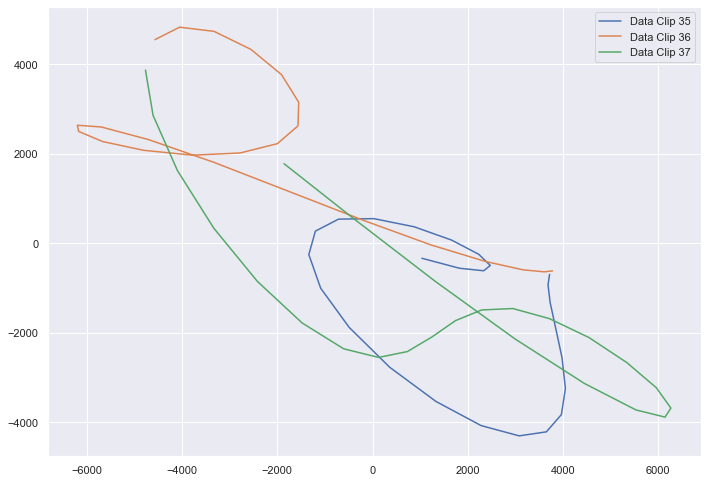

In [93]:
est_per = 25
num_test = 3
inital_clip = 35
end_clip = inital_clip+num_test

line_refernce = np.linspace(0,est_per,est_per)

for i in range (inital_clip,end_clip):
    plt.plot(TX_Q_data[i*est_per:(i+1)*(est_per)],RX_Q_data[delay+i*est_per:(i+1)*(est_per)+delay],    label='Data Clip {}'.format(i))  

#plt.step(line_refernce,np.squeeze(every_pure_input).T[0:test_size][0],label='Pure_Input')      
#plt.step(line_refernce, every_input[0:test_size],label='Curropted Signal') 
#plt.step(line_refernce,every_input[0:test_size],label='Input Signals After The Channels')       
plt.legend()

In [94]:
# Data Preparation
len_data =len(RX_Q_data)
assert(len(RX_Q_data) == len(TX_Q_data))

training_data   = int(len_data*0.05)
test_data       = len_data- training_data

# Generate Inpute Sequance
mem = 6
every_input     = generate_input(TX_Q_data[0:training_data],mem,training_data)
RX_Q_to_train   = RX_Q_data[delay:training_data+delay]
RX_Q_to_train_2 = -RX_Q_to_train
RX_Q_to_train = np.concatenate((RX_Q_to_train,RX_Q_to_train_2),axis=1)

819


In [95]:
#RNN Class

# It is possible to use this class when there the inputs are one dimensional

class RNN:
    def __init__(self,input_len,output_len,mem,hidden_size =15):
        self.Wya = np.random.randn(output_len,hidden_size)/1000
        self.Wax = np.random.randn(hidden_size,input_len)/1000
        self.Waa = np.random.randn(hidden_size,hidden_size)/1000

        self.by = np.zeros((output_len,1))
        self.ba = np.zeros((hidden_size,1))

        self.hidden_size    = hidden_size
        self.output_len     = output_len
        self.input_len      = input_len

        self.mem = mem
        self.overshoot = 0

    def forward_prop(self,measurement):
       
        self.last_as = [0]*len(measurement)
        # Number of a parameter depends on number of measurement
        # Measurment intake depends on memory parameter
    
        a =  np.zeros((self.hidden_size, 1))
        self.last_as = { 0: a }
        self.last_measurement = measurement


        for i ,x in enumerate(measurement):
            # x value of the input
            # i sequance of the input

            k = self.Wax*x
            j = np.matmul(self.Waa,a)
            assert(np.shape(k) == (self.hidden_size,1))
            a = np.tanh(k + j + self.ba)

            # Store the a for backprop
            self.last_as[i+1] = a 

        
        #Store the inputs for backprop

        y = np.matmul(self.Wya,a) + self.by
        assert(np.shape(y) == (self.output_len,1))
        
        return y, a


    def back_prop(self,dL_dy,learning_rate = 0.001):
        dWya =  np.zeros(self.Wya.shape)
        dWax =  np.zeros(self.Wax.shape)
        dWaa =  np.zeros(self.Waa.shape)
        dby  =  np.zeros(self.by.shape)
        dba  =  np.zeros(self.ba.shape)

        n = len(self.last_measurement)
        dWya = np.matmul(dL_dy,self.last_as[n].T)
        dby = dL_dy
        
        temp = 1
        dh = np.matmul(self.Wya.T,dL_dy)
        
        for i in reversed(range(n)):
            temp =((1 - self.last_as[i + 1] ** 2))
            self.last_measurement = np.reshape((self.last_measurement),(self.mem,1))
            temp = temp*dh
            dWaa += temp * self.last_as[i].T
            dWax +=  temp*self.last_measurement[i]       
            dba  += temp
            dh = np.matmul(self.Waa.T,temp)
        
        #   Exploding and Vanishing Gradient problem 
        #   Work around the solution
        #for d in [dWax, dWaa, dWya, dba, dby]:
        #    np.clip(d, -1, 1, out=d)

        self.Wax = self.Wax  - learning_rate*dWax
        self.Waa = self.Waa  - learning_rate*dWaa
        self.Wya = self.Wya  - learning_rate*dWya

        self.by =  self.by -learning_rate*dby
        self.ba =  self.ba -learning_rate*dba 

In [96]:
def linear(xs):
  # Applies the Softmax Function to the input array.
  return xs

--- Epoch 100
Train:	Loss [4451796.87795549]     | Accuracy:    0.0
--- Epoch 200
Train:	Loss [4450081.73836711]     | Accuracy:    0.0
--- Epoch 300
Train:	Loss [4449651.43696866]     | Accuracy:    0.0
--- Epoch 400
Train:	Loss [4449577.19069281]     | Accuracy:    0.0
--- Epoch 500
Train:	Loss [4449600.63001129]     | Accuracy:    0.0
--- Epoch 600
Train:	Loss [4449640.23104734]     | Accuracy:    0.0
--- Epoch 700
Train:	Loss [4449673.72943193]     | Accuracy:    0.0
--- Epoch 800
Train:	Loss [4449697.6620087]     | Accuracy:    0.0
--- Epoch 900
Train:	Loss [4449713.61400826]     | Accuracy:    0.0
--- Epoch 1000
Train:	Loss [4449723.89959042]     | Accuracy:    0.0


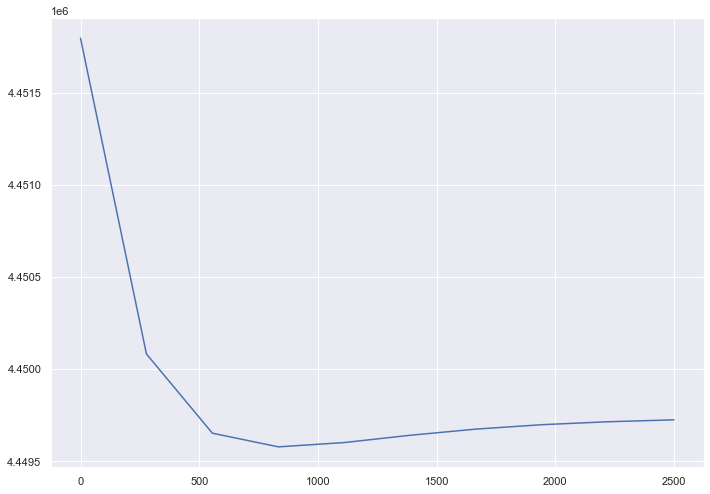

In [97]:
# Initialize our RNN!

rnn = RNN(1, 2,mem)
loss_data = []

def processData(data,refernce,backprop=True ):
  '''
  Returns the RNN's loss and accuracy for the given data.
  - data is a dictionary mapping text to True or False.
  - backprop determines if the backward phase should be run.
  '''
  items = data

  loss = 0
  num_correct = 0

  for x in range (len(items)):
    inputs = items[x]  
    target = refernce[x]
    #print("Input >>>>",inputs,"Targets >>>>", target)
    # Forward
    out, _ = rnn.forward_prop(inputs)

    probs = linear(out)
    target = np.reshape(target,(2,1))
    #print("Probs >>>>",probs,np.shape(probs))
    # Calculate loss / accuracy
    loss += (target-probs[0])**2

    #If Classification
    #num_correct += int(np.argmax(probs) == target)

    if backprop:
        # Build dL/dy
        d_L_d_y = -2*(target-probs)

        # Backward
        rnn.back_prop(d_L_d_y)

  return loss / len(data),   num_correct / len(data)


# Training loop
for epoch in range(1000):

  train_loss, train_acc = processData(data = every_input, refernce=RX_Q_to_train )

  if epoch % 100 == 99:
    print('--- Epoch %d' % (epoch + 1))
    print("Train:\tLoss" ,train_loss[0],"    | Accuracy:   ", train_acc)
    loss_data.append(train_loss[0])
    test_loss, test_acc = processData(data = every_input, backprop=True,refernce=RX_Q_to_train)
  
line_refernce = np.linspace(0,2500,len(loss_data))
plt.plot(line_refernce,loss_data)  

In [98]:
i = 0
est_per = 100
every_input = generate_input(TX_Q_data[i*est_per:(i+1)*(est_per)],mem,len(TX_Q_data[i:(i+1)*(est_per)]))

RX_Q_to_test = RX_Q_data[delay+i*est_per:(i+1)*(est_per)+delay]
RX_Q_to_test_2 = -RX_Q_to_test
RX_Q_to_test = np.concatenate((RX_Q_to_test,RX_Q_to_test_2),axis=1)
RX_Q_to_test = np.reshape(RX_Q_to_test.T[1],(len(RX_Q_to_test.T[1]),1))

100


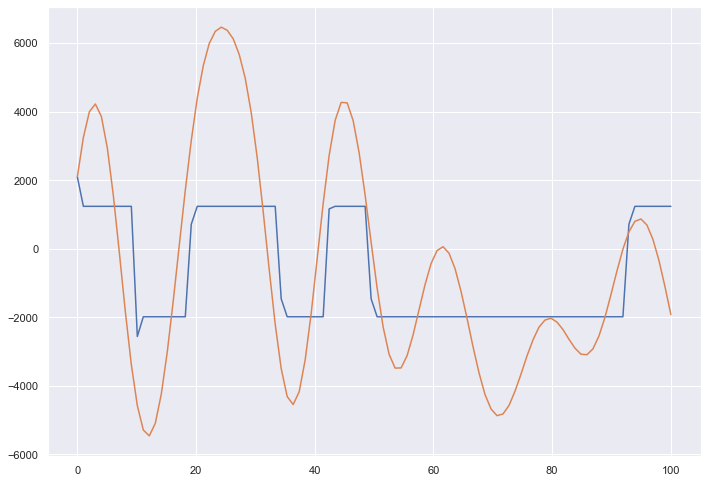

In [99]:
store_results = []
for i in range(len(every_input)):
    out, _ = rnn.forward_prop(every_input[i])
    store_results.append(out[1][:])

line_refernce = np.linspace(0,len(store_results),len(store_results))
plt.plot(line_refernce,store_results)  
plt.plot(line_refernce,RX_Q_to_test)  


In [ ]:
## The Probelm Vanishing Gradiant ?? 
#  Checking now


In [101]:
#RNN Class

# It is possible to use this class when there the inputs are one dimensional

class RNN:
    def __init__(self,input_len,output_len,mem,hidden_size =20):
        self.Wya = np.random.randn(output_len,hidden_size)/1000
        self.Wax = np.random.randn(hidden_size,input_len)/1000
        self.Waa = np.random.randn(hidden_size,hidden_size)/1000

        self.by = np.zeros((output_len,1))
        self.ba = np.zeros((hidden_size,1))

        self.hidden_size    = hidden_size
        self.output_len     = output_len
        self.input_len      = input_len

        self.mem = mem
        self.overshoot = 0

    def forward_prop(self,measurement):
       
        self.last_as = [0]*len(measurement)
        # Number of a parameter depends on number of measurement
        # Measurment intake depends on memory parameter
    
        a =  np.zeros((self.hidden_size, 1))
        self.last_as = { 0: a }
        self.last_measurement = measurement


        for i ,x in enumerate(measurement):
            # x value of the input
            # i sequance of the input

            k = self.Wax*x
            j = np.matmul(self.Waa,a)
            assert(np.shape(k) == (self.hidden_size,1))
            a = np.tanh(k + j + self.ba)

            # Store the a for backprop
            self.last_as[i+1] = a 

        
        #Store the inputs for backprop

        y = np.matmul(self.Wya,a) + self.by
        assert(np.shape(y) == (self.output_len,1))
        
        return y, a


    def back_prop(self,dL_dy,learning_rate = 0.001):
        dWya =  np.zeros(self.Wya.shape)
        dWax =  np.zeros(self.Wax.shape)
        dWaa =  np.zeros(self.Waa.shape)
        dby  =  np.zeros(self.by.shape)
        dba  =  np.zeros(self.ba.shape)

        n = len(self.last_measurement)
        dWya = np.matmul(dL_dy,self.last_as[n].T)
        dby = dL_dy
        
        temp = 1
        dh = np.matmul(self.Wya.T,dL_dy)
        
        for i in reversed(range(n)):
            temp =((1 - self.last_as[i + 1] ** 2))
            self.last_measurement = np.reshape((self.last_measurement),(self.mem,1))
            temp = temp*dh
            dWaa += temp * self.last_as[i].T
            dWax +=  temp*self.last_measurement[i]       
            dba  += temp
            dh = np.matmul(self.Waa.T,temp)
        
        #   Exploding and Vanishing Gradient problem 
        #   Work around the solution
        for d in [dWax, dWaa, dWya, dba, dby]:
            np.clip(d, -1, 1, out=d)

        self.Wax = self.Wax  - learning_rate*dWax
        self.Waa = self.Waa  - learning_rate*dWaa
        self.Wya = self.Wya  - learning_rate*dWya

        self.by =  self.by -learning_rate*dby
        self.ba =  self.ba -learning_rate*dba 

--- Epoch 100
Train:	Loss [9963459.14949069]     | Accuracy:    0.0
--- Epoch 200
Train:	Loss [9334180.35742121]     | Accuracy:    0.0
--- Epoch 300
Train:	Loss [8776235.07546389]     | Accuracy:    0.0
--- Epoch 400
Train:	Loss [8271646.98145165]     | Accuracy:    0.0
--- Epoch 500
Train:	Loss [7821136.90352159]     | Accuracy:    0.0
--- Epoch 600
Train:	Loss [7425316.29143641]     | Accuracy:    0.0
--- Epoch 700
Train:	Loss [7067176.50400113]     | Accuracy:    0.0
--- Epoch 800
Train:	Loss [6748232.17827112]     | Accuracy:    0.0
--- Epoch 900
Train:	Loss [6455639.86016268]     | Accuracy:    0.0
--- Epoch 1000
Train:	Loss [6201101.59835838]     | Accuracy:    0.0


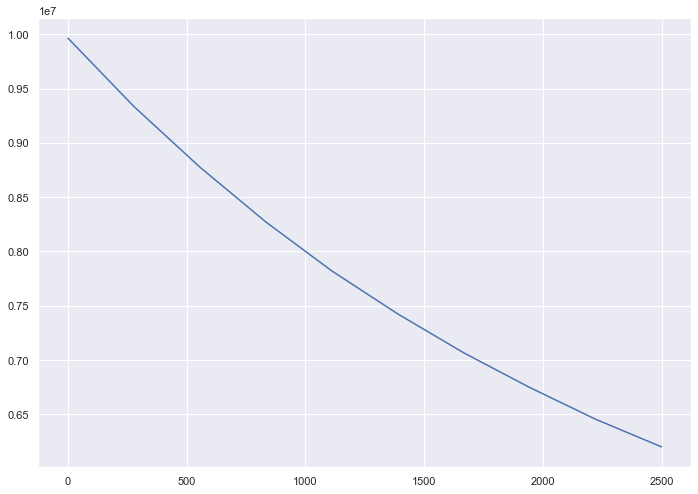

In [102]:
# Initialize our RNN!

rnn = RNN(1, 2,mem)
loss_data = []

def processData(data,refernce,backprop=True ):
  '''
  Returns the RNN's loss and accuracy for the given data.
  - data is a dictionary mapping text to True or False.
  - backprop determines if the backward phase should be run.
  '''
  items = data

  loss = 0
  num_correct = 0

  for x in range (len(items)):
    inputs = items[x]  
    target = refernce[x]
    #print("Input >>>>",inputs,"Targets >>>>", target)
    # Forward
    out, _ = rnn.forward_prop(inputs)

    probs = linear(out)
    target = np.reshape(target,(2,1))
    #print("Probs >>>>",probs,np.shape(probs))
    # Calculate loss / accuracy
    loss += (target-probs[0])**2

    #If Classification
    #num_correct += int(np.argmax(probs) == target)

    if backprop:
        # Build dL/dy
        d_L_d_y = -2*(target-probs)

        # Backward
        rnn.back_prop(d_L_d_y)

  return loss / len(data),   num_correct / len(data)


# Training loop
for epoch in range(1000):

  train_loss, train_acc = processData(data = every_input, refernce=RX_Q_to_train )

  if epoch % 100 == 99:
    print('--- Epoch %d' % (epoch + 1))
    print("Train:\tLoss" ,train_loss[0],"    | Accuracy:   ", train_acc)
    loss_data.append(train_loss[0])
    test_loss, test_acc = processData(data = every_input, backprop=True,refernce=RX_Q_to_train)
  
line_refernce = np.linspace(0,2500,len(loss_data))
plt.plot(line_refernce,loss_data)  

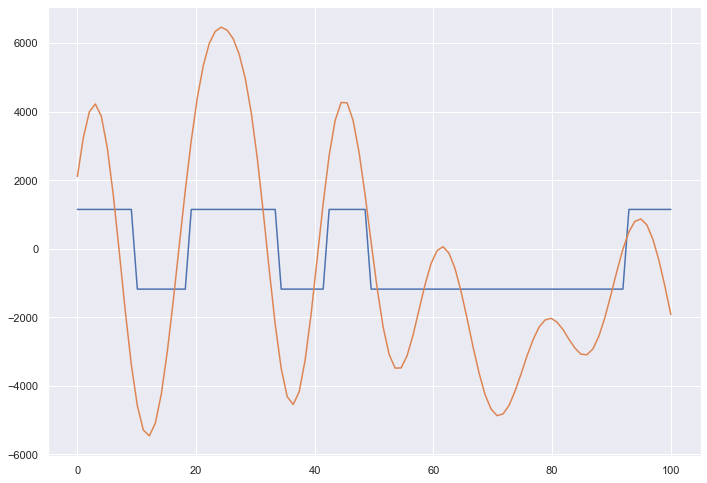

In [103]:
store_results = []
for i in range(len(every_input)):
    out, _ = rnn.forward_prop(every_input[i])
    store_results.append(out[1][:])

line_refernce = np.linspace(0,len(store_results),len(store_results))
plt.plot(line_refernce,store_results)  
plt.plot(line_refernce,RX_Q_to_test)  

In [ ]:
## Is the problem learning rate ??
# Chekcing Below

In [105]:
#RNN Class

# It is possible to use this class when there the inputs are one dimensional

class RNN:
    def __init__(self,input_len,output_len,mem,hidden_size =20):
        self.Wya = np.random.randn(output_len,hidden_size)/1000
        self.Wax = np.random.randn(hidden_size,input_len)/1000
        self.Waa = np.random.randn(hidden_size,hidden_size)/1000

        self.by = np.zeros((output_len,1))
        self.ba = np.zeros((hidden_size,1))

        self.hidden_size    = hidden_size
        self.output_len     = output_len
        self.input_len      = input_len

        self.mem = mem
        self.overshoot = 0

    def forward_prop(self,measurement):
       
        self.last_as = [0]*len(measurement)
        # Number of a parameter depends on number of measurement
        # Measurment intake depends on memory parameter
    
        a =  np.zeros((self.hidden_size, 1))
        self.last_as = { 0: a }
        self.last_measurement = measurement


        for i ,x in enumerate(measurement):
            # x value of the input
            # i sequance of the input

            k = self.Wax*x
            j = np.matmul(self.Waa,a)
            assert(np.shape(k) == (self.hidden_size,1))
            a = np.tanh(k + j + self.ba)

            # Store the a for backprop
            self.last_as[i+1] = a 

        
        #Store the inputs for backprop

        y = np.matmul(self.Wya,a) + self.by
        assert(np.shape(y) == (self.output_len,1))
        
        return y, a


    def back_prop(self,dL_dy,learning_rate = 0.01):
        dWya =  np.zeros(self.Wya.shape)
        dWax =  np.zeros(self.Wax.shape)
        dWaa =  np.zeros(self.Waa.shape)
        dby  =  np.zeros(self.by.shape)
        dba  =  np.zeros(self.ba.shape)

        n = len(self.last_measurement)
        dWya = np.matmul(dL_dy,self.last_as[n].T)
        dby = dL_dy
        
        temp = 1
        dh = np.matmul(self.Wya.T,dL_dy)
        
        for i in reversed(range(n)):
            temp =((1 - self.last_as[i + 1] ** 2))
            self.last_measurement = np.reshape((self.last_measurement),(self.mem,1))
            temp = temp*dh
            dWaa += temp * self.last_as[i].T
            dWax +=  temp*self.last_measurement[i]       
            dba  += temp
            dh = np.matmul(self.Waa.T,temp)
        
        #   Exploding and Vanishing Gradient problem 
        #   Work around the solution
        for d in [dWax, dWaa, dWya, dba, dby]:
            np.clip(d, -1, 1, out=d)

        self.Wax = self.Wax  - learning_rate*dWax
        self.Waa = self.Waa  - learning_rate*dWaa
        self.Wya = self.Wya  - learning_rate*dWya

        self.by =  self.by -learning_rate*dby
        self.ba =  self.ba -learning_rate*dba 

--- Epoch 100
Train:	Loss [6236393.76561404]     | Accuracy:    0.0
--- Epoch 200
Train:	Loss [4797889.39774621]     | Accuracy:    0.0
--- Epoch 300
Train:	Loss [4482828.63770492]     | Accuracy:    0.0
--- Epoch 400
Train:	Loss [4455250.39545812]     | Accuracy:    0.0
--- Epoch 500
Train:	Loss [4480803.43373505]     | Accuracy:    0.0
--- Epoch 600
Train:	Loss [4508718.792301]     | Accuracy:    0.0
--- Epoch 700
Train:	Loss [4523667.27274056]     | Accuracy:    0.0
--- Epoch 800
Train:	Loss [4534922.48913103]     | Accuracy:    0.0
--- Epoch 900
Train:	Loss [4545670.75649222]     | Accuracy:    0.0
--- Epoch 1000
Train:	Loss [4546217.66632688]     | Accuracy:    0.0


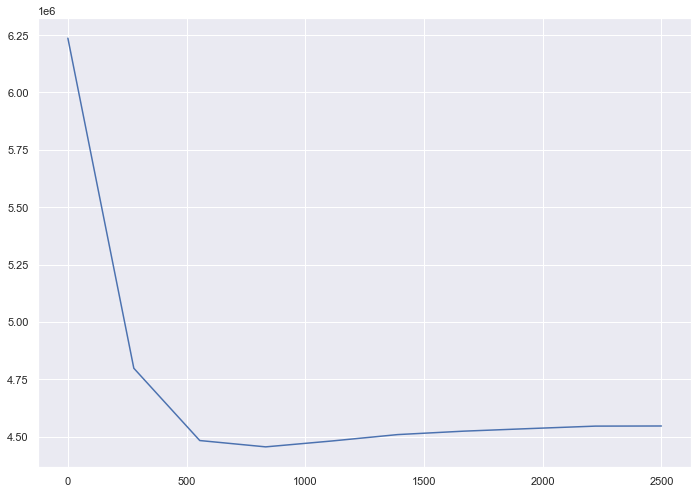

In [106]:
# Initialize our RNN!

rnn = RNN(1, 2,mem)
loss_data = []

def processData(data,refernce,backprop=True ):
  '''
  Returns the RNN's loss and accuracy for the given data.
  - data is a dictionary mapping text to True or False.
  - backprop determines if the backward phase should be run.
  '''
  items = data

  loss = 0
  num_correct = 0

  for x in range (len(items)):
    inputs = items[x]  
    target = refernce[x]
    #print("Input >>>>",inputs,"Targets >>>>", target)
    # Forward
    out, _ = rnn.forward_prop(inputs)

    probs = linear(out)
    target = np.reshape(target,(2,1))
    #print("Probs >>>>",probs,np.shape(probs))
    # Calculate loss / accuracy
    loss += (target-probs[0])**2

    #If Classification
    #num_correct += int(np.argmax(probs) == target)

    if backprop:
        # Build dL/dy
        d_L_d_y = -2*(target-probs)

        # Backward
        rnn.back_prop(d_L_d_y)

  return loss / len(data),   num_correct / len(data)


# Training loop
for epoch in range(1000):

  train_loss, train_acc = processData(data = every_input, refernce=RX_Q_to_train )

  if epoch % 100 == 99:
    print('--- Epoch %d' % (epoch + 1))
    print("Train:\tLoss" ,train_loss[0],"    | Accuracy:   ", train_acc)
    loss_data.append(train_loss[0])
    test_loss, test_acc = processData(data = every_input, backprop=True,refernce=RX_Q_to_train)
  
line_refernce = np.linspace(0,2500,len(loss_data))
plt.plot(line_refernce,loss_data)  

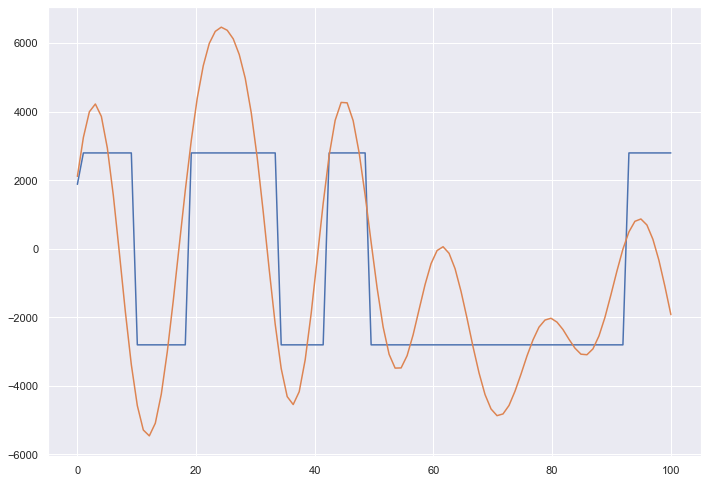

In [107]:
store_results = []
for i in range(len(every_input)):
    out, _ = rnn.forward_prop(every_input[i])
    store_results.append(out[1][:])

line_refernce = np.linspace(0,len(store_results),len(store_results))
plt.plot(line_refernce,store_results)  
plt.plot(line_refernce,RX_Q_to_test)  

In [ ]:

## Problem is vanishing gradient !!!